INFO: ======================================================================
INFO: SOFTWARE-DEFINED SAR IMAGING PIPELINE
INFO: ======================================================================
INFO: 
[1/6] Generating LFM chirp signal...
INFO: Generated chirp: B=100.0 MHz, T=3.0 μs, K=33.33 THz/s


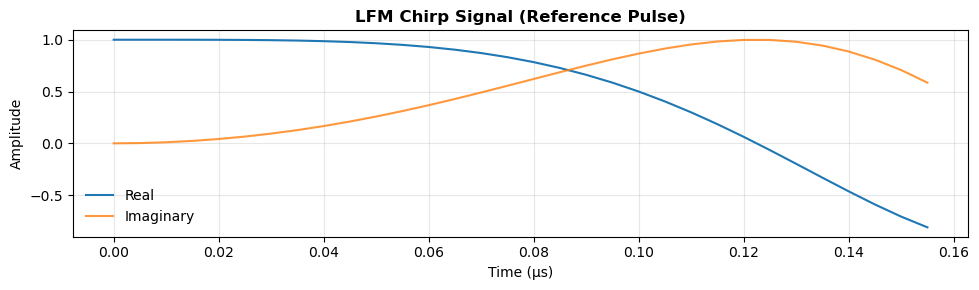

INFO: 
[2/6] Simulating raw SAR data...
INFO: Simulated raw SAR data: 128×128, SNR targets: 5.0, 2.0


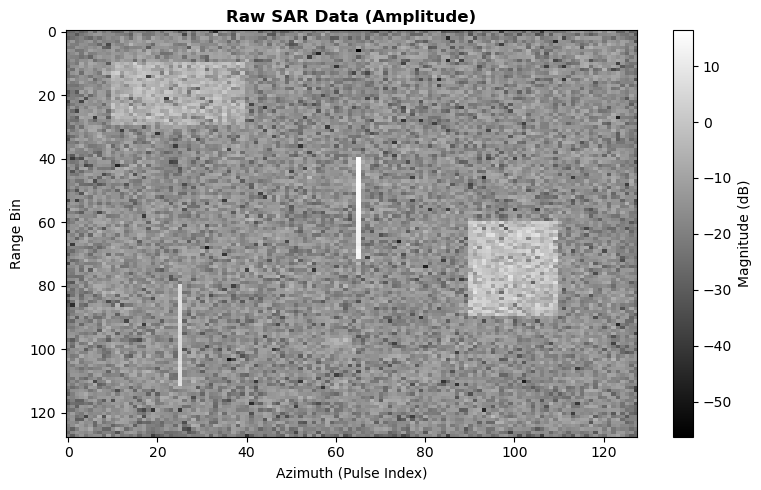

INFO: 
[3/6] Performing range compression...
INFO: Range compression complete via FFT matched filtering


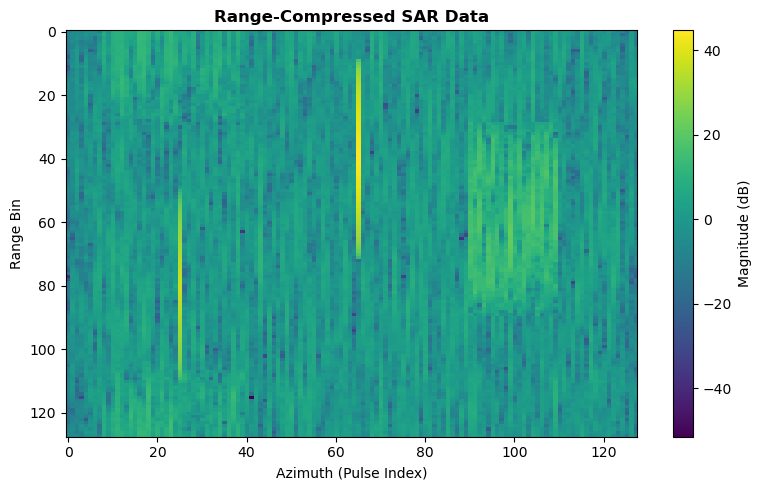

INFO: 
[4/6] Performing azimuth compression...
INFO: Azimuth compression complete via Doppler matched filtering


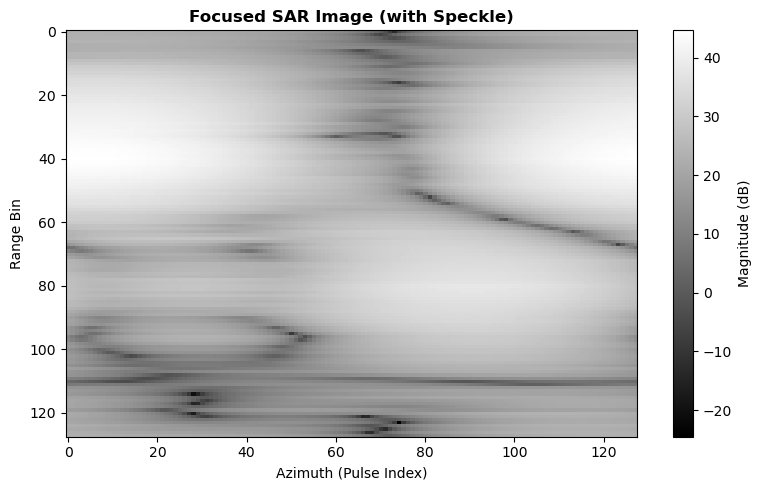

INFO: 
[5/6] Computing image quality metrics...


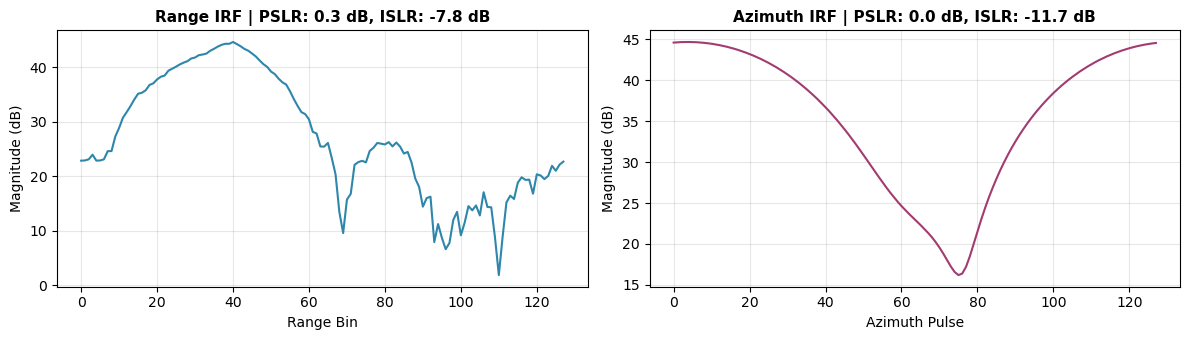

INFO: ENL (uniform patch): 9.26
INFO: PSLR (Range/Azimuth): 0.33 dB / 0.01 dB
INFO: ISLR (Range/Azimuth): -7.85 dB / -11.72 dB
INFO: 
[6/6] Applying Lee filter for despeckling...
INFO: Lee filter applied (window=7x7)


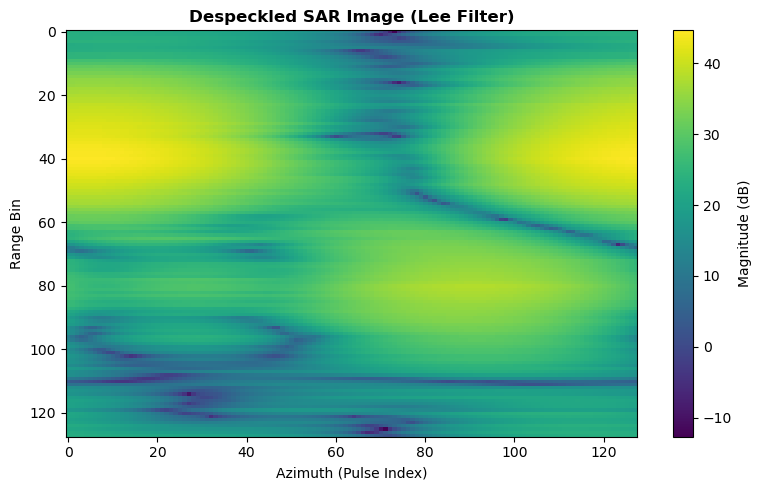

INFO: 
INFO: PIPELINE EXECUTION COMPLETE
INFO: ======================================================================


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, windows
from typing import Tuple, Dict
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)


# ==============================================================================
# CONFIGURATION
# ==============================================================================

CONFIG = {
    'radar': {
        'bandwidth': 100e6,        # Hz - Chirp bandwidth
        'pulse_duration': 3e-6,    # seconds - Chirp duration
        'speed_of_light': 3e8,     # m/s
    },
    'scene': {
        'n_azimuth': 128,          # Number of azimuth pulses
        'n_range': 128,            # Number of range bins
    },
    'simulation': {
        'thermal_noise_sigma': 0.15,
        'speckle_corr_kernel': 9,
        'motion_phase_jitter': 0.05,
    },
    'processing': {
        'lee_window_size': 7,
        'azimuth_bandwidth': 0.5,
    },
}


# ==============================================================================
# SIGNAL GENERATION
# ==============================================================================

def generate_chirp(config: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate Linear Frequency Modulated (LFM) chirp signal.
    
    Parameters:
        config: Configuration dictionary containing radar parameters
        
    Returns:
        t: Time vector (s)
        chirp: Complex chirp signal
    """
    B = config['radar']['bandwidth']
    T = config['radar']['pulse_duration']
    N_rg = config['scene']['n_range']
    
    fs = 2 * B  # Nyquist sampling rate
    K = B / T   # Chirp rate (Hz/s)
    
    t = np.arange(N_rg) / fs
    chirp_len = N_rg // 4
    chirp = np.exp(1j * np.pi * K * t[:chirp_len]**2)
    
    logger.info(f"Generated chirp: B={B/1e6:.1f} MHz, T={T*1e6:.1f} μs, K={K/1e12:.2f} THz/s")
    return t[:chirp_len], chirp


# ==============================================================================
# RAW DATA SIMULATION
# ==============================================================================

def simulate_raw_sar_data(chirp: np.ndarray, config: Dict) -> np.ndarray:
    """
    Simulate raw SAR data including thermal noise, targets, clutter, 
    speckle, and platform motion errors.
    
    Parameters:
        chirp: Reference chirp signal
        config: Configuration dictionary
        
    Returns:
        raw_data: Simulated 2D complex SAR data (range x azimuth)
    """
    N_rg = config['scene']['n_range']
    N_az = config['scene']['n_azimuth']
    noise_sigma = config['simulation']['thermal_noise_sigma']
    
    # Initialize with thermal noise
    raw_data = (np.random.randn(N_rg, N_az) + 
                1j * np.random.randn(N_rg, N_az)) * noise_sigma
    
    # Add point targets
    chirp_len = len(chirp)
    raw_data[40:40+chirp_len, 65] += chirp * 5.0  # Strong target
    raw_data[80:80+chirp_len, 25] += chirp * 2.0  # Weak target
    
    # Add extended clutter patches
    _add_clutter_patch(raw_data, 10, 10, 20, 30, 0.4)  # Vegetation
    _add_clutter_patch(raw_data, 60, 90, 30, 20, 0.8)  # Urban
    
    # Apply correlated speckle
    speckle_kernel = config['simulation']['speckle_corr_kernel']
    raw_data *= _generate_correlated_speckle(raw_data.shape, speckle_kernel)
    
    # Add platform motion errors
    raw_data = _apply_motion_errors(raw_data, config)
    
    logger.info(f"Simulated raw SAR data: {N_rg}×{N_az}, SNR targets: 5.0, 2.0")
    return raw_data


def _add_clutter_patch(data: np.ndarray, top: int, left: int, 
                       height: int, width: int, rcs: float) -> None:
    """Add extended clutter patch to scene (in-place modification)."""
    patch = (np.random.randn(height, width) + 
             1j * np.random.randn(height, width)) * rcs
    data[top:top+height, left:left+width] += patch


def _generate_correlated_speckle(shape: Tuple, kernel_size: int) -> np.ndarray:
    """Generate spatially correlated multiplicative speckle noise."""
    L = 1.0
    speckle = np.random.gamma(L, 1.0/L, size=shape)
    
    # Spatial correlation via convolution
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    speckle = fftconvolve(speckle, kernel, mode='same')
    speckle /= speckle.mean()  # Normalize to unit mean
    
    return speckle


def _apply_motion_errors(data: np.ndarray, config: Dict) -> np.ndarray:
    """Apply platform motion-induced phase errors."""
    N_az = config['scene']['n_azimuth']
    jitter_std = config['simulation']['motion_phase_jitter']
    
    # Phase ramp + jitter per pulse
    phase_ramp = np.exp(1j * np.linspace(0, 0.6, N_az))
    phase_jitter = np.exp(1j * np.random.randn(N_az) * jitter_std)
    phase_error = phase_ramp * phase_jitter
    
    return data * phase_error[np.newaxis, :]


# ==============================================================================
# RANGE COMPRESSION
# ==============================================================================

def range_compression(raw_data: np.ndarray, chirp: np.ndarray, 
                     config: Dict) -> np.ndarray:
    """
    Perform matched filtering for range compression using FFT convolution.
    
    Parameters:
        raw_data: Raw SAR data
        chirp: Reference chirp signal
        config: Configuration dictionary
        
    Returns:
        rc_data: Range-compressed data
    """
    N_rg = config['scene']['n_range']
    N_az = config['scene']['n_azimuth']
    
    # Matched filter in frequency domain
    ref_fft = np.conj(np.fft.fft(chirp, N_rg))
    rc_data = np.zeros_like(raw_data, dtype=complex)
    
    for az in range(N_az):
        signal_fft = np.fft.fft(raw_data[:, az])
        compressed_fft = signal_fft * ref_fft
        rc_data[:, az] = np.fft.ifft(compressed_fft)
    
    logger.info("Range compression complete via FFT matched filtering")
    return rc_data


# ==============================================================================
# AZIMUTH COMPRESSION
# ==============================================================================

def azimuth_compression(rc_data: np.ndarray, config: Dict) -> np.ndarray:
    """
    Perform azimuth compression using Doppler-based matched filtering.
    
    Parameters:
        rc_data: Range-compressed data
        config: Configuration dictionary
        
    Returns:
        focused_data: Fully focused SAR image
    """
    N_az = config['scene']['n_azimuth']
    N_rg = config['scene']['n_range']
    az_bw = config['processing']['azimuth_bandwidth']
    
    # Generate azimuth reference function
    az_time = np.arange(N_az) - N_az/2
    az_ref_td = np.sinc(az_bw * az_time / N_az) * windows.hann(N_az)
    az_ref_fd = np.conj(np.fft.fft(az_ref_td, N_az))
    
    # Matched filtering in azimuth
    focused_data = np.zeros_like(rc_data, dtype=complex)
    for rg in range(N_rg):
        signal_fft = np.fft.fft(rc_data[rg, :])
        focused_fft = signal_fft * az_ref_fd
        focused_data[rg, :] = np.fft.ifft(focused_fft)
    
    # Add residual noise
    focused_data += (np.random.randn(*focused_data.shape) + 
                     1j * np.random.randn(*focused_data.shape)) * 0.01
    
    logger.info("Azimuth compression complete via Doppler matched filtering")
    return focused_data


# ==============================================================================
# DESPECKLING
# ==============================================================================

def lee_filter(img: np.ndarray, window_size: int = 7) -> np.ndarray:
    """
    Apply Lee adaptive filter to reduce speckle noise.
    
    Parameters:
        img: Input amplitude image
        window_size: Local window size (must be odd)
        
    Returns:
        filtered: Despeckled amplitude image
    """
    intensity = img**2
    pad = window_size // 2
    padded = np.pad(intensity, pad, mode='reflect')
    filtered_int = np.zeros_like(intensity)
    
    for i in range(intensity.shape[0]):
        for j in range(intensity.shape[1]):
            local_window = padded[i:i+window_size, j:j+window_size]
            local_mean = local_window.mean()
            local_var = local_window.var()
            
            # Adaptive weighting
            noise_var = local_mean**2  # Simplified noise estimate
            weight = max(0, (local_var - noise_var) / (local_var + 1e-12))
            
            filtered_int[i, j] = local_mean + (1 - weight) * (intensity[i, j] - local_mean)
    
    logger.info(f"Lee filter applied (window={window_size}x{window_size})")
    return np.sqrt(filtered_int)


# ==============================================================================
# QUALITY METRICS
# ==============================================================================

def compute_pslr_islr(slice_db: np.ndarray) -> Tuple[float, float]:
    """
    Compute Peak Sidelobe Ratio (PSLR) and Integrated Sidelobe Ratio (ISLR).
    
    Parameters:
        slice_db: 1D impulse response in dB
        
    Returns:
        pslr: Peak sidelobe ratio (dB)
        islr: Integrated sidelobe ratio (dB)
    """
    peak = np.max(slice_db)
    peak_idx = np.argmax(slice_db)
    
    # PSLR: exclude mainlobe ±1 sample
    sidelobes = np.copy(slice_db)
    sidelobes[max(0, peak_idx-1):min(len(slice_db), peak_idx+2)] = -999
    pslr = peak - np.max(sidelobes)
    
    # ISLR: energy ratio
    linear = 10**(slice_db / 10.0)
    mainlobe_idx = np.arange(max(0, peak_idx-1), min(len(slice_db), peak_idx+2))
    mainlobe_energy = np.sum(linear[mainlobe_idx])
    sidelobe_energy = np.sum(linear) - mainlobe_energy
    islr = 10 * np.log10(mainlobe_energy / (sidelobe_energy + 1e-12))
    
    return pslr, islr


def compute_enl(img: np.ndarray, patch_coords: Tuple) -> float:
    """
    Compute Equivalent Number of Looks (ENL) for speckle assessment.
    
    Parameters:
        img: Amplitude image
        patch_coords: (top, left, height, width)
        
    Returns:
        enl: Equivalent number of looks
    """
    top, left, h, w = patch_coords
    patch = img[top:top+h, left:left+w]
    mean_val = patch.mean()
    var_val = patch.var()
    enl = (mean_val**2) / (var_val + 1e-12)
    return enl


# ==============================================================================
# VISUALIZATION UTILITIES
# ==============================================================================

def plot_chirp(t: np.ndarray, chirp: np.ndarray) -> None:
    """Plot chirp signal time-domain representation."""
    plt.figure(figsize=(10, 3))
    plt.plot(t * 1e6, np.real(chirp), label="Real", linewidth=1.5)
    plt.plot(t * 1e6, np.imag(chirp), label="Imaginary", linewidth=1.5, alpha=0.8)
    plt.title("LFM Chirp Signal (Reference Pulse)", fontsize=12, fontweight='bold')
    plt.xlabel("Time (μs)", fontsize=10)
    plt.ylabel("Amplitude", fontsize=10)
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_sar_image(data: np.ndarray, title: str, cmap: str = 'gray') -> None:
    """Plot SAR image in dB scale."""
    plt.figure(figsize=(8, 5))
    img_db = 20 * np.log10(np.abs(data) + 1e-9)
    plt.imshow(img_db, aspect='auto', cmap=cmap, interpolation='nearest')
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel("Azimuth (Pulse Index)", fontsize=10)
    plt.ylabel("Range Bin", fontsize=10)
    cbar = plt.colorbar()
    cbar.set_label("Magnitude (dB)", fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_impulse_response(range_slice: np.ndarray, azimuth_slice: np.ndarray,
                         metrics: Dict) -> None:
    """Plot range and azimuth impulse response functions with metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
    
    axes[0].plot(range_slice, linewidth=1.5, color='#2E86AB')
    axes[0].set_title(f"Range IRF | PSLR: {metrics['pslr_r']:.1f} dB, ISLR: {metrics['islr_r']:.1f} dB",
                     fontsize=11, fontweight='bold')
    axes[0].set_xlabel("Range Bin", fontsize=10)
    axes[0].set_ylabel("Magnitude (dB)", fontsize=10)
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(azimuth_slice, linewidth=1.5, color='#A23B72')
    axes[1].set_title(f"Azimuth IRF | PSLR: {metrics['pslr_a']:.1f} dB, ISLR: {metrics['islr_a']:.1f} dB",
                     fontsize=11, fontweight='bold')
    axes[1].set_xlabel("Azimuth Pulse", fontsize=10)
    axes[1].set_ylabel("Magnitude (dB)", fontsize=10)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ==============================================================================
# MAIN PIPELINE
# ==============================================================================

def main():
    """Execute end-to-end SAR imaging pipeline."""
    
    logger.info("=" * 70)
    logger.info("SOFTWARE-DEFINED SAR IMAGING PIPELINE")
    logger.info("=" * 70)
    
    # Step 1: Generate chirp signal
    logger.info("\n[1/6] Generating LFM chirp signal...")
    t, chirp = generate_chirp(CONFIG)
    plot_chirp(t, chirp)
    
    # Step 2: Simulate raw SAR data
    logger.info("\n[2/6] Simulating raw SAR data...")
    raw_data = simulate_raw_sar_data(chirp, CONFIG)
    plot_sar_image(raw_data, "Raw SAR Data (Amplitude)", cmap='gray')
    
    # Step 3: Range compression
    logger.info("\n[3/6] Performing range compression...")
    rc_data = range_compression(raw_data, chirp, CONFIG)
    plot_sar_image(rc_data, "Range-Compressed SAR Data", cmap='viridis')
    
    # Step 4: Azimuth compression
    logger.info("\n[4/6] Performing azimuth compression...")
    focused_data = azimuth_compression(rc_data, CONFIG)
    amp_img = np.abs(focused_data)
    plot_sar_image(focused_data, "Focused SAR Image (with Speckle)", cmap='gray')
    
    # Step 5: Quality metrics
    logger.info("\n[5/6] Computing image quality metrics...")
    rg_idx, az_idx = np.unravel_index(np.argmax(amp_img), amp_img.shape)
    range_slice = 20 * np.log10(amp_img[:, az_idx] + 1e-9)
    azimuth_slice = 20 * np.log10(amp_img[rg_idx, :] + 1e-9)
    
    pslr_r, islr_r = compute_pslr_islr(range_slice)
    pslr_a, islr_a = compute_pslr_islr(azimuth_slice)
    enl = compute_enl(amp_img, (12, 12, 20, 20))
    
    metrics = {
        'pslr_r': pslr_r, 'islr_r': islr_r,
        'pslr_a': pslr_a, 'islr_a': islr_a,
        'enl': enl
    }
    
    plot_impulse_response(range_slice, azimuth_slice, metrics)
    logger.info(f"ENL (uniform patch): {enl:.2f}")
    logger.info(f"PSLR (Range/Azimuth): {pslr_r:.2f} dB / {pslr_a:.2f} dB")
    logger.info(f"ISLR (Range/Azimuth): {islr_r:.2f} dB / {islr_a:.2f} dB")
    
    # Step 6: Despeckling
    logger.info("\n[6/6] Applying Lee filter for despeckling...")
    window_size = CONFIG['processing']['lee_window_size']
    despeckled = lee_filter(amp_img, window_size)
    plot_sar_image(despeckled, "Despeckled SAR Image (Lee Filter)", cmap='viridis')
    
    logger.info("\n" + "=" * 70)
    logger.info("PIPELINE EXECUTION COMPLETE")
    logger.info("=" * 70)


if __name__ == "__main__":
    main()
